In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
#import librosa
#import utils
#import ast
import pickle
#import fma_utils
#import kapre
#from kapre.time_frequency import Spectrogram, Melspectrogram
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio


#import os
#import shutil
#from IPython.display import display, Audio


In [2]:
#tf.debugging.set_log_device_placement(True)

In [3]:
#tf.config.experimental.list_physical_devices('GPU')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUDIO_DIR = 'data/fma_small'
SR = 16000
BATCH_SIZE = 16
#INP_SHAPE = (1190700, 2)
#INP_SHAPE = (BATCH_SIZE, 160000, 2)
#MFCC_SHAPE = (BATCH_SIZE, 160000, 36)
START =  441000
END = 661500

In [6]:
#load 
fma_multi = pickle.load(open("saved/fma_multi.p", "rb"))

In [7]:
fma_multi.head()

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_large/000/000002.mp3,[21],Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,[21],Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,[10],Pop
20,training,large,data/fma_large/000/000020.mp3,"[17, 10, 76, 103]",NaN


In [8]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_multi.index[fma_multi['subset'] == 'small']

In [9]:
fma_small = fma_multi.loc[subset]

In [10]:
fma_small['filepath'] = fma_small['filepath'].str.replace('large','small')

In [11]:
fma_small

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_small/000/000002.mp3,[21],Hip-Hop
5,training,small,data/fma_small/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_small/000/000010.mp3,[10],Pop
140,training,small,data/fma_small/000/000140.mp3,[17],Folk
141,training,small,data/fma_small/000/000141.mp3,[17],Folk
...,...,...,...,...,...
154308,test,small,data/fma_small/154/154308.mp3,"[811, 539, 21]",Hip-Hop
154309,test,small,data/fma_small/154/154309.mp3,"[811, 539, 21]",Hip-Hop
154413,training,small,data/fma_small/154/154413.mp3,"[10, 76]",Pop


In [12]:
drop3=pickle.load(open("saved/drop3.p","rb"))

In [13]:
fma_small.drop(drop3, inplace=True)

In [14]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = fma_small.index[fma_small['split'] == 'training']
val = fma_small.index[fma_small['split'] == 'validation']
test = fma_small.index[fma_small['split'] == 'test']

In [15]:
print('training set size: ', len(train))
print('validation set size: ', len(val))
print('test set size: ', len(test))

training set size:  6310
validation set size:  793
test set size:  794


In [16]:
#single label
enc = LabelEncoder()
mlb = MultiLabelBinarizer()

X_train = fma_small['filepath'].loc[train]
X_val = fma_small['filepath'].loc[val]
X_test = fma_small['filepath'].loc[test]
y_train = enc.fit_transform(fma_small['genre_top'].loc[train])
y_val = enc.transform(fma_small['genre_top'].loc[val])
y_test = enc.transform(fma_small['genre_top'].loc[test])

In [ ]:
#multi label
#enc = LabelEncoder()
enc = MultiLabelBinarizer()

X_train = fma_small['filepath'].loc[train]
X_val = fma_small['filepath'].loc[val]
X_test = fma_small['filepath'].loc[test]
y_train = enc.fit_transform(fma_small['genres_all'].loc[train])
y_val = enc.transform(fma_small['genres_all'].loc[val])
y_test = enc.transform(fma_small['genres_all'].loc[test])

For the MFCC parser, we need to choose what frequency spectrum is important to us. We know a few things:
* Humans can only hear below 20kHz or less. With a cutoff of 3kHz, the sound will be less pleasing but we won't loose any information we need.
* The lower range of human hearing is between 20Hz and 40Hz. But mp3 files almost always cut off higher than 40Hz. The lowest open string on a bass is 41Hz so using 40 as a cutoff will not drop any musical information.
* The fundamentals of all the notes played in most music is between 50Hz and 1000Hz (e.g. an operatic soprano's high C is 1046Hz).  
  
Given these points, we will do the following:
* Take a mel spectrogram of 73 mels between 41Hz and 2624Hz. These should then represent every note in that 6 octave range.
* Transform it to a db (log 10) scale.
* Take the MFCCs from 
Also, fidelity is not very important in this case, we are not audiophiles listening, a grosser sampling rate than would be pleasant will carry more than enough information for classification, so we will downsample from 44100 samples/second to 16000 in order to save space.

In [17]:
@tf.function
def parse_audio_mfcc(filename, label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    audio = audio[START:END] #crop to uniform size
    audio = tf.math.reduce_mean(audio, axis=1) #stereo to mono

    spectrogram = tfio.experimental.audio.spectrogram(audio, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.experimental.audio.melscale(spectrogram, rate=44100, mels=108, fmin=40, fmax=8000)
    dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(mel_spectrogram, top_db=80)
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(dbscale_mel_spectrogram)[1:,12:51]
    mfcc = tf.squeeze(mfcc)
    return mfcc, label

In [22]:
@tf.function
def parse_audio_spec(filename, label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    audio = audio[START:END] #crop to uniform size
    audio = tf.math.reduce_mean(audio, axis=1) #stereo to mono

    spectrogram = tfio.experimental.audio.spectrogram(audio, nfft=256, window=512, stride=256)[1:,:]
    spectrogram = tf.squeeze(spectrogram)
    return spectrogram, label

In [19]:
def parse_audio(filename,  label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)   
      
    audio = audio[START:END] #crop to uniform size
    
    #resample to reduse data size, we don't need 44.1kHz fidelity, 16k will be plenty
    audio = tfio.audio.resample(audio, 44100, SR)
    return audio, label

In [20]:
t_mfcc,l = parse_audio_mfcc('data/fma_small/154/154413.mp3',1)
t_mfcc.shape

TensorShape([861, 39])

In [23]:
t_spec,l = parse_audio_spec('data/fma_small/154/154413.mp3',1)
t_spec.shape

TensorShape([861, 129])

In [25]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [26]:
#data pipeline
def get_data(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio_mfcc, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [27]:
#data pipeline
def get_data_mfcc(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio_mfcc, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [28]:
#data pipeline
def get_data_spec(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio_spec, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [23]:
#mfcc
train_ds = get_data_mfcc(train_ds)
val_ds = get_data_mfcc(val_ds)
test_ds = get_data_mfcc(test_ds)
INP_SHAPE = t_mfcc.shape

In [24]:
#Classify on MFCC
#basic CNN architecture from TF documentation

keras.backend.clear_session()
model = models.Sequential()
#model.add(tf.keras.layers.experimental.preprocessing.Normalization(
  #  axis=-1, dtype=None, input_shape=INP_SHAPE))

model.add(layers.Reshape((123,21,13), input_shape=INP_SHAPE))

model.add(layers.BatchNormalization(axis=-1))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(4,2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, 2, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
#model.add(layers.Reshape(0,))

model.add(layers.Dense(32, activation='relu'))
#model.add(tf.keras.backend.squeeze())
model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=0.05,momentum=0.01, nesterov=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 862, 43, 3)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 862, 43, 3)        12        
_________________________________________________________________
conv2d (Conv2D)              (None, 860, 41, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 430, 20, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 428, 18, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 213, 8, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 211, 6, 128)       1

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        epochs=40,                    
                        validation_data=val_ds)

Epoch 1/40
395/395 [==============================] - 48s 122ms/step - loss: 2.0578 - accuracy: 0.1681 - val_loss: 2.0455 - val_accuracy: 0.1740
Epoch 2/40
395/395 [==============================] - 49s 124ms/step - loss: 2.0342 - accuracy: 0.1990 - val_loss: 2.0299 - val_accuracy: 0.2005
Epoch 3/40
395/395 [==============================] - 49s 125ms/step - loss: 2.0264 - accuracy: 0.1990 - val_loss: 2.0141 - val_accuracy: 0.2219
Epoch 4/40
395/395 [==============================] - 53s 134ms/step - loss: 2.0154 - accuracy: 0.2182 - val_loss: 2.1198 - val_accuracy: 0.1816
Epoch 5/40
395/395 [==============================] - 49s 124ms/step - loss: 2.0022 - accuracy: 0.2252 - val_loss: 2.0036 - val_accuracy: 0.2257
Epoch 6/40
395/395 [==============================] - 47s 120ms/step - loss: 1.9946 - accuracy: 0.2266 - val_loss: 2.0178 - val_accuracy: 0.2169
Epoch 7/40
395/395 [==============================] - 47s 120ms/step - loss: 1.9893 - accuracy: 0.2317 - val_loss: 2.0205 - val_ac

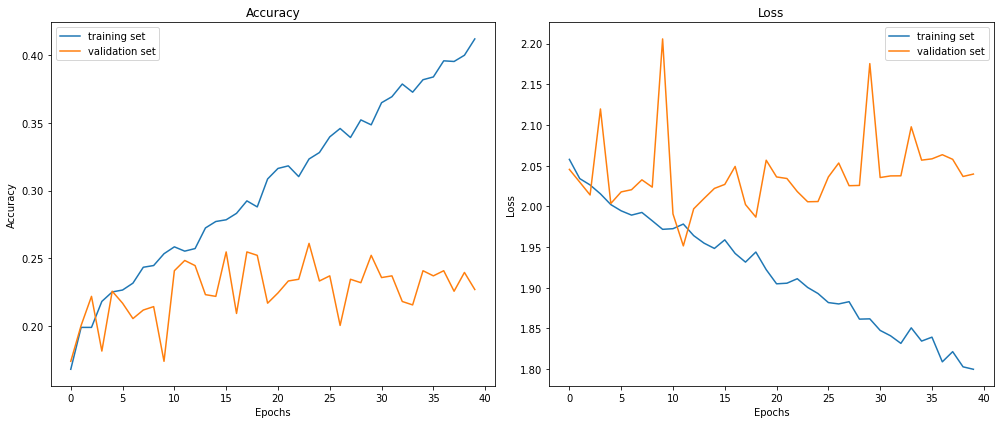

In [26]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
results = model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 5s 105ms/step - loss: 2.0445 - accuracy: 0.2469


In [ ]:
y_pred = np.argmax(model.predict(X_test) > 0.5, axis=1)

In [ ]:
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

In [29]:
#spec
train_ds = get_data_spec(train_ds)
val_ds = get_data_spec(val_ds)
test_ds = get_data_spec(test_ds)
INP_SHAPE = t_spec.shape

In [30]:
#Classify on spectrogram
#basic CNN architecture from TF documentation

keras.backend.clear_session()
model = models.Sequential()
#model.add(tf.keras.layers.experimental.preprocessing.Normalization(
  #  axis=-1, dtype=None, input_shape=INP_SHAPE))


model.add(layers.Reshape((861,43,3), input_shape=INP_SHAPE)) #spec shape
model.add(layers.BatchNormalization(axis=-1))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(4,2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, 2, activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
#model.add(layers.Reshape(0,))

model.add(layers.Dense(32, activation='relu'))
#model.add(tf.keras.backend.squeeze())
model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=0.05,momentum=0.01, nesterov=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 861, 43, 3)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 861, 43, 3)        12        
_________________________________________________________________
conv2d (Conv2D)              (None, 859, 41, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 429, 20, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 427, 18, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 212, 8, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 6, 128)       1

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        epochs=20,                    
                        validation_data=val_ds)

Epoch 1/20
395/395 [==============================] - 48s 122ms/step - loss: 2.0711 - accuracy: 0.1433 - val_loss: 2.0587 - val_accuracy: 0.1362
Epoch 2/20
395/395 [==============================] - 48s 122ms/step - loss: 2.0368 - accuracy: 0.1808 - val_loss: 2.0122 - val_accuracy: 0.2333
Epoch 3/20
395/395 [==============================] - 46s 116ms/step - loss: 2.0231 - accuracy: 0.2079 - val_loss: 2.0166 - val_accuracy: 0.1917
Epoch 4/20
395/395 [==============================] - 47s 119ms/step - loss: 2.0160 - accuracy: 0.2160 - val_loss: 2.0682 - val_accuracy: 0.1639
Epoch 5/20
395/395 [==============================] - 47s 118ms/step - loss: 2.0085 - accuracy: 0.2246 - val_loss: 1.9979 - val_accuracy: 0.2320
Epoch 6/20
395/395 [==============================] - 47s 120ms/step - loss: 2.0025 - accuracy: 0.2281 - val_loss: 2.0070 - val_accuracy: 0.2232
Epoch 7/20
395/395 [==============================] - 49s 125ms/step - loss: 2.0029 - accuracy: 0.2307 - val_loss: 1.9961 - val_ac

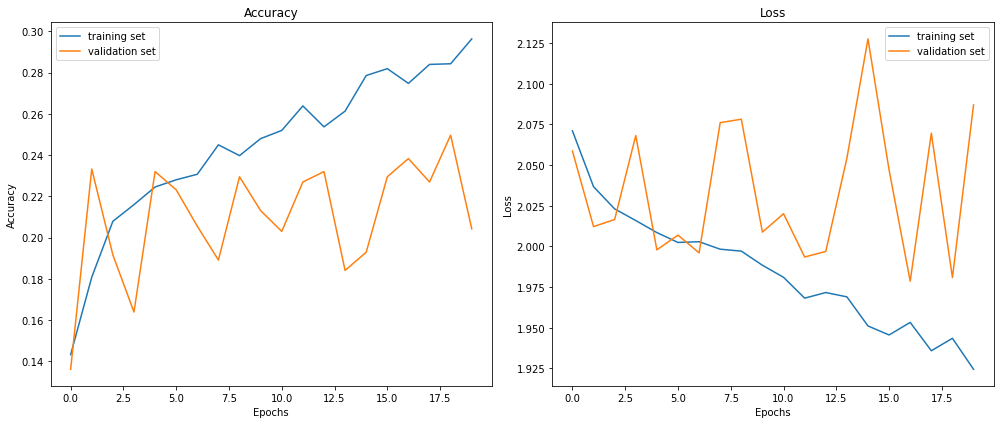

In [34]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
results = model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 4s 90ms/step - loss: 2.1105 - accuracy: 0.2267


In [ ]:
y_pred = np.argmax(model.predict(X_test) > 0.5, axis=1)

In [ ]:
y_pred

In [ ]:
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))